In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt 
import tqdm
import numpy as np

In [ ]:
def download_data(image_size, dataset_type):
    """Download the MNIST dataset and create a data loader."""

    transformations = torchvision.transforms.Compose([
      torchvision.transforms.Resize(image_size),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean=(0.5), std=(0.5))
    ])

    if dataset_type == 'MNIST':
      # MNIST train set
      mnist_train = torchvision.datasets.MNIST(
        root="./dataset",
        train=True,
        download=True,
        transform=transformations
      )
      return mnist_train
    elif dataset_type == 'FashionMNIST':
      # FashionMNIST train set
      mnist_train = torchvision.datasets.FashionMNIST(
        root="./dataset",
        train=True,
        download=True,
        transform=transformations
      )
      return mnist_train
    return None

# MNIST

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./dataset
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([64, 64])


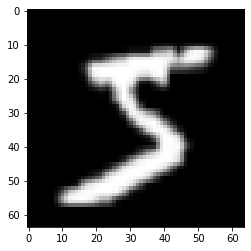

In [ ]:
batch_size = 64
image_size = 64
mnist_train = download_data(image_size, 'MNIST')
print(mnist_train)

print(mnist_train.classes)

# visualize first image
print(mnist_train[0][0][0].shape)
plt.imshow(mnist_train[0][0][0], cmap='Greys_r')

In [ ]:
train_loader = torch.utils.data.DataLoader(
    mnist_train, batch_size=batch_size, drop_last=True, shuffle=True
)

for images, labels in train_loader:
    print(images.shape, labels.shape)
    break
    
# num minibatches 
print(len(train_loader))

torch.Size([64, 1, 64, 64]) torch.Size([64])
937


In [ ]:
class Generator(torch.nn.Module):
    def __init__(self, hidden_dim, channel_in=100, channel_out=32):
        super().__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=channel_in, out_channels=channel_out*8, kernel_size=4, stride=1, padding=0),
            torch.nn.BatchNorm2d(num_features=channel_out*8),
            torch.nn.ReLU(inplace=True),
            )
        self.conv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=channel_out*8, out_channels=channel_out*4, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(num_features=channel_out*4),
            torch.nn.ReLU(inplace=True),
            )
        self.conv3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=channel_out*4, out_channels=channel_out*2, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(num_features=channel_out*2),
            torch.nn.ReLU(inplace=True),
            )
        self.conv4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=channel_out*2, out_channels=channel_out, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(num_features=channel_out),
            torch.nn.ReLU(inplace=True),
            )
      
        self.conv5 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=channel_out, out_channels=1, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh(),
            )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self, hidden_dim, channel_in=1, channel_out=32):
        super().__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=channel_in, out_channels=channel_out, kernel_size=4, stride=2, padding=1), 
                                         torch.nn.LeakyReLU(0.2, inplace=True)
                                         )
        self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=channel_out, out_channels=channel_out*2, kernel_size=4, stride=2, padding=1),
                                         torch.nn.BatchNorm2d(channel_out*2),
                                         torch.nn.LeakyReLU(0.2, inplace=True)
                                         )
        self.conv3 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=channel_out*2, out_channels=channel_out*4, kernel_size=4, stride=2, padding=1),
                                         torch.nn.BatchNorm2d(channel_out*4),
                                         torch.nn.LeakyReLU(0.2, inplace=True)
                                         )
        self.conv4 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=channel_out*4, out_channels=channel_out*8, kernel_size=4, stride=2, padding=1),
                                         torch.nn.BatchNorm2d(channel_out*8),
                                         torch.nn.LeakyReLU(0.2, inplace=True)
                                         )
        self.conv5 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=channel_out*8, out_channels=1, kernel_size=4, stride=1, padding=0),
                                         torch.nn.Sigmoid()
                                         )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x.squeeze().unsqueeze(dim=1)

In [ ]:
hidden_dim = 256

In [ ]:
generator = Generator(hidden_dim)
discriminator = Discriminator(hidden_dim)

d_optim, g_optim = torch.optim.Adam(
    discriminator.parameters(), lr=0.001, betas=[0.5, 0.999]
), torch.optim.Adam(
    generator.parameters(), lr=0.001, betas=[0.5, 0.999]
)
criterion = torch.nn.BCELoss()

In [ ]:
def generate_fake_samples(generator):
    latents = torch.randn((batch_size, 100)).unsqueeze(dim=2).unsqueeze(dim=3)    
    fake_samples = generator(latents)

    return fake_samples

In [ ]:
def display_fake_samples(generated_images, print_in_color=False):
    fig = plt.figure(figsize=(8, 8))
    columns, rows = 8, 8
    for i in range(1, columns*rows +1):
        img = torch.unsqueeze(generated_images[i-1], dim=0).view((image_size, image_size))
        fig.add_subplot(rows, columns, i)
        if print_in_color:
          plt.imshow(img)
        else:
          plt.imshow(img, cmap='Greys_r')
    plt.show()

In [ ]:
def train_v1(train_loader, generator, discriminator, d_optim, g_optim, num_epochs=10, print_in_color=False):
    for epoch in range(num_epochs):
        cnt = 0
        for images, labels in train_loader:
            cnt += 1
            real_samples = images
            fake_samples = generate_fake_samples(generator)

            # display fake samples
            if cnt % 200 == 0:
                if print_in_color:
                  display_fake_samples(fake_samples.detach(), print_in_color=True)
                else:
                  display_fake_samples(fake_samples.detach())
            # calculate discriminator loss
            d_optim.zero_grad()
            d_out = discriminator(real_samples)
            one_out = torch.ones(batch_size, 1)

            d_real_loss = criterion(d_out, one_out)
            if cnt % 100 == 0:
                print("Epoch: ", epoch)
                print("Discriminator Real Loss: ", d_real_loss)

            out_fake = discriminator(fake_samples.detach())
            d_fake_loss = criterion(out_fake, torch.zeros(batch_size, 1))
            if cnt % 200 == 0:
                print("Discriminator Fake Loss: ", d_fake_loss)

            # backprop gradients, update weights
            d_real_loss.backward()
            d_fake_loss.backward()
            d_optim.step()

            # calculate generator loss
            g_optim.zero_grad()
            g_loss = criterion(discriminator(fake_samples), torch.ones(batch_size, 1))
            if cnt % 200 == 0:
                print("Generator Real Loss: ", g_loss)
            # backprop gradients, update weights
            g_loss.backward()
            g_optim.step()

Epoch:  0
Discriminator Real Loss:  tensor(0.2910, grad_fn=<BinaryCrossEntropyBackward0>)


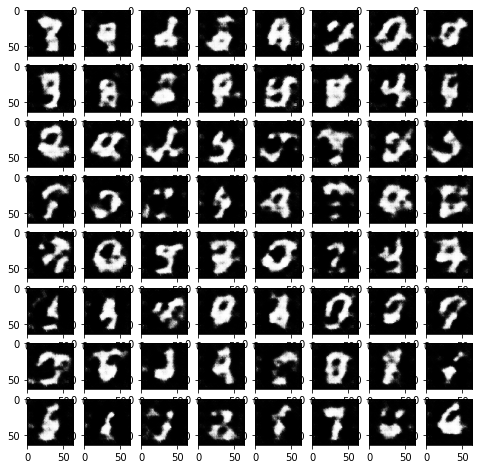

Epoch:  0
Discriminator Real Loss:  tensor(0.0651, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(1.0271, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(5.6860, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  0
Discriminator Real Loss:  tensor(1.0133, grad_fn=<BinaryCrossEntropyBackward0>)


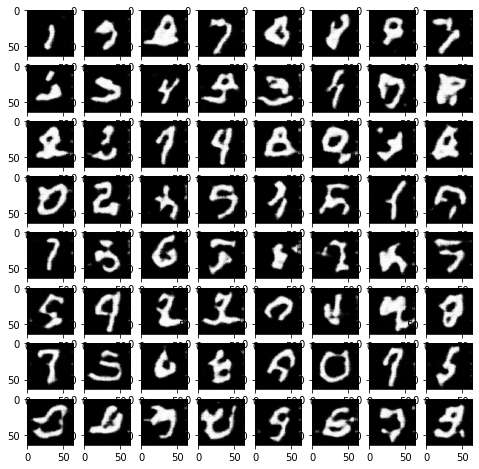

Epoch:  0
Discriminator Real Loss:  tensor(1.1396, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.0936, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(0.8083, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  0
Discriminator Real Loss:  tensor(0.5347, grad_fn=<BinaryCrossEntropyBackward0>)


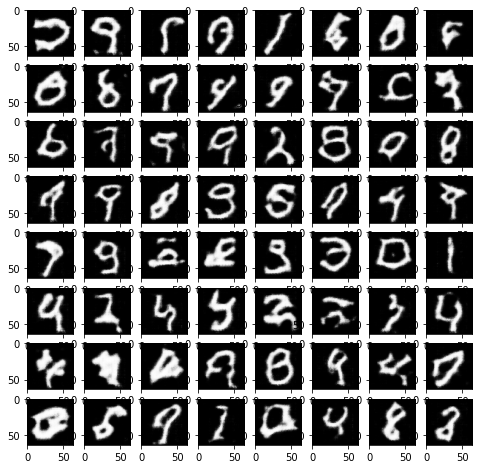

Epoch:  0
Discriminator Real Loss:  tensor(0.5631, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.4945, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(1.4168, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  0
Discriminator Real Loss:  tensor(0.2648, grad_fn=<BinaryCrossEntropyBackward0>)


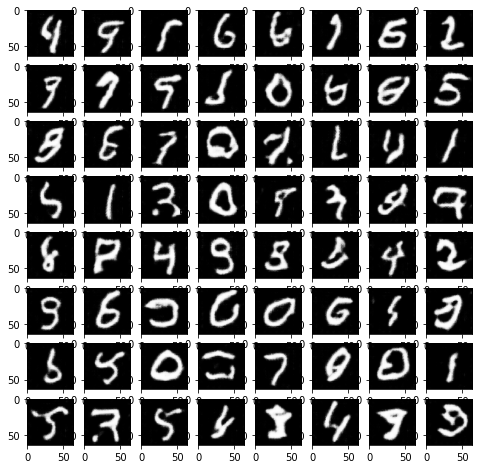

Epoch:  0
Discriminator Real Loss:  tensor(0.4119, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.2133, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(1.5205, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  0
Discriminator Real Loss:  tensor(0.6213, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Discriminator Real Loss:  tensor(0.1287, grad_fn=<BinaryCrossEntropyBackward0>)


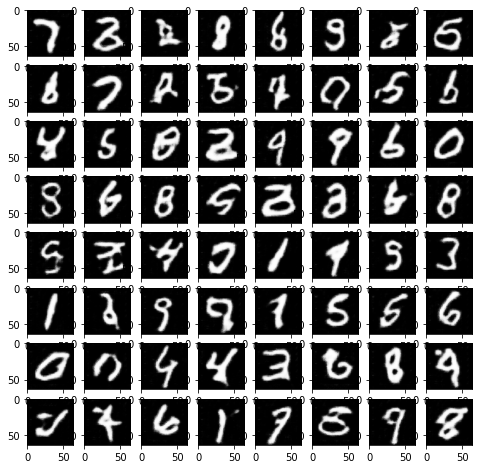

Epoch:  1
Discriminator Real Loss:  tensor(0.2353, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.3640, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(2.7281, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Discriminator Real Loss:  tensor(1.9653, grad_fn=<BinaryCrossEntropyBackward0>)


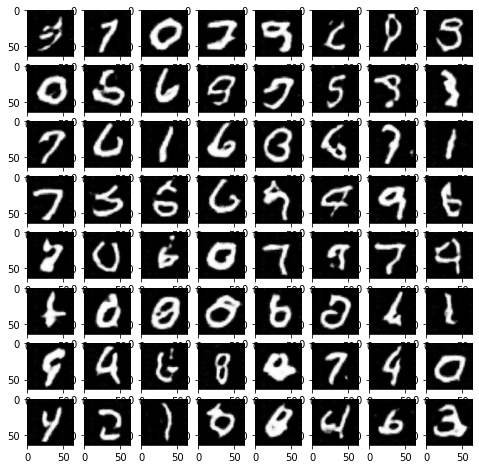

Epoch:  1
Discriminator Real Loss:  tensor(0.2494, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.2345, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(2.9442, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Discriminator Real Loss:  tensor(0.9228, grad_fn=<BinaryCrossEntropyBackward0>)


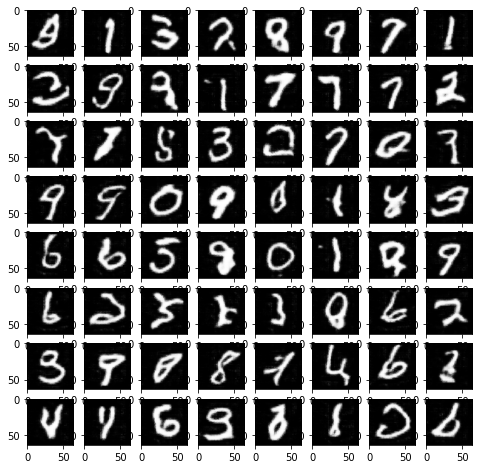

Epoch:  1
Discriminator Real Loss:  tensor(0.7404, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.3766, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(1.3622, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Discriminator Real Loss:  tensor(0.0335, grad_fn=<BinaryCrossEntropyBackward0>)


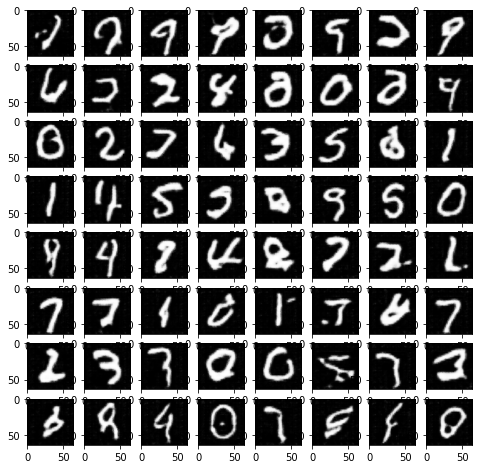

Epoch:  1
Discriminator Real Loss:  tensor(0.1855, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(2.6343, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Discriminator Real Loss:  tensor(0.0341, grad_fn=<BinaryCrossEntropyBackward0>)


In [ ]:
train_v1(train_loader, generator, discriminator, d_optim, g_optim, num_epochs=2)

# Fashion MNIST

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./dataset
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
torch.Size([64, 64])


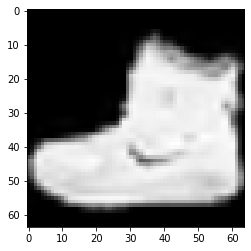

In [ ]:
fashion_mnist_train = download_data(image_size, 'FashionMNIST')
print(fashion_mnist_train)

print(fashion_mnist_train.classes)

# visualize first image
print(fashion_mnist_train[0][0][0].shape)
plt.imshow(fashion_mnist_train[0][0][0], cmap='Greys_r')

In [ ]:
train_loader = torch.utils.data.DataLoader(
    fashion_mnist_train, batch_size=batch_size, drop_last=True, shuffle=True
)

for images, labels in train_loader:
    print(images.shape, labels.shape)
    break
    
# num minibatches 
print(len(train_loader))

torch.Size([64, 1, 64, 64]) torch.Size([64])
937


In [ ]:
generator_fashion = Generator(hidden_dim)
discriminator_fashion = Discriminator(hidden_dim)

d_optim_fashion, g_optim_fashion = torch.optim.Adam(
    discriminator_fashion.parameters(), lr=0.001, betas=[0.5, 0.999]
), torch.optim.Adam(
    generator_fashion.parameters(), lr=0.001, betas=[0.5, 0.999]
)
criterion = torch.nn.BCELoss()

Epoch:  0
Discriminator Real Loss:  tensor(0.2053, grad_fn=<BinaryCrossEntropyBackward0>)


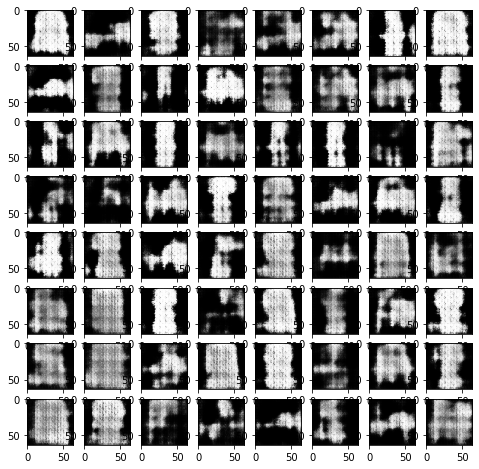

Epoch:  0
Discriminator Real Loss:  tensor(0.4895, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.3803, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(1.4005, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  0
Discriminator Real Loss:  tensor(0.4481, grad_fn=<BinaryCrossEntropyBackward0>)


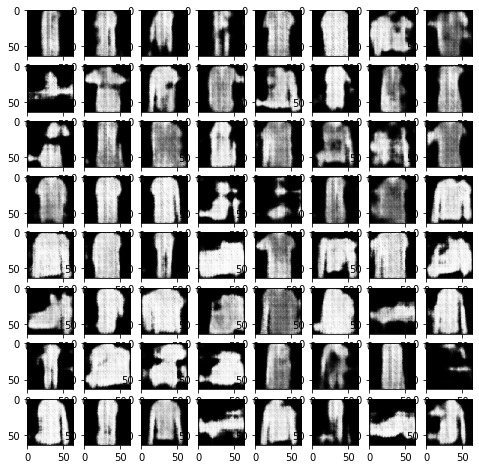

Epoch:  0
Discriminator Real Loss:  tensor(0.5516, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.3663, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(1.6846, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  0
Discriminator Real Loss:  tensor(0.4182, grad_fn=<BinaryCrossEntropyBackward0>)


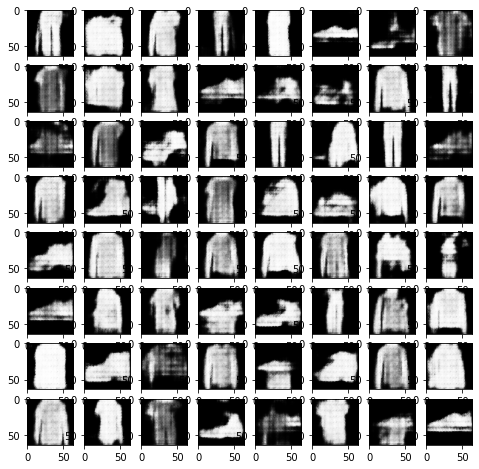

Epoch:  0
Discriminator Real Loss:  tensor(0.5666, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.6348, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(1.9303, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  0
Discriminator Real Loss:  tensor(0.3359, grad_fn=<BinaryCrossEntropyBackward0>)


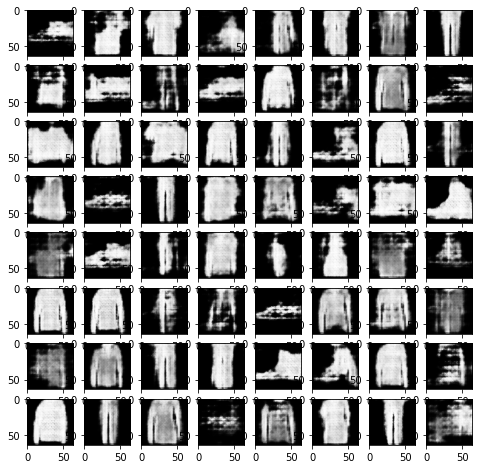

Epoch:  0
Discriminator Real Loss:  tensor(0.6336, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.1849, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(1.7962, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  0
Discriminator Real Loss:  tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Discriminator Real Loss:  tensor(0.3942, grad_fn=<BinaryCrossEntropyBackward0>)


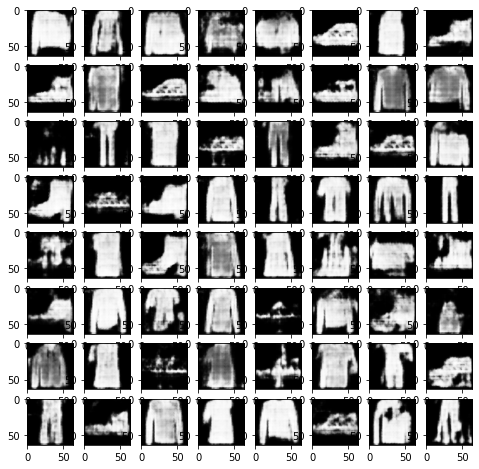

Epoch:  1
Discriminator Real Loss:  tensor(0.3642, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.0500, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(2.6544, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Discriminator Real Loss:  tensor(0.0622, grad_fn=<BinaryCrossEntropyBackward0>)


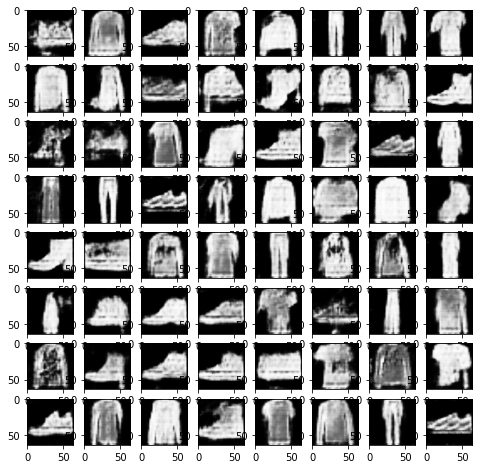

Epoch:  1
Discriminator Real Loss:  tensor(0.0600, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.1829, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(4.8341, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Discriminator Real Loss:  tensor(0.0578, grad_fn=<BinaryCrossEntropyBackward0>)


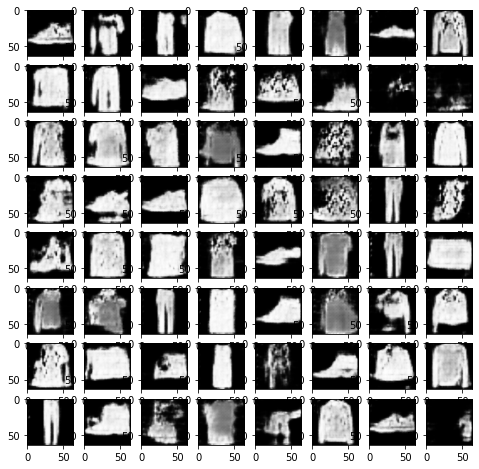

Epoch:  1
Discriminator Real Loss:  tensor(0.1544, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.0174, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(4.4831, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Discriminator Real Loss:  tensor(0.1008, grad_fn=<BinaryCrossEntropyBackward0>)


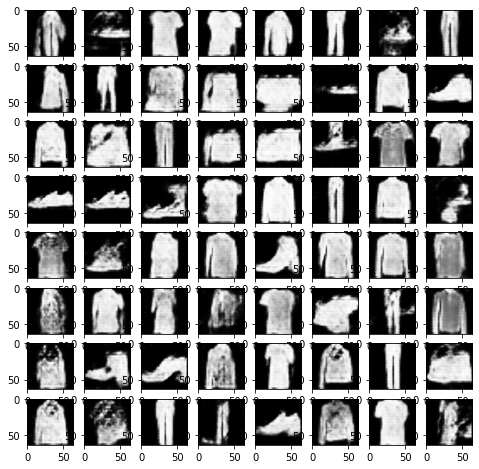

Epoch:  1
Discriminator Real Loss:  tensor(0.0462, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.0179, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(4.9396, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Discriminator Real Loss:  tensor(0.2028, grad_fn=<BinaryCrossEntropyBackward0>)


In [ ]:
train_v1(train_loader, generator_fashion, discriminator_fashion, d_optim_fashion, g_optim_fashion, num_epochs=2)

# Celeb Faces

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the stories in the training and validation set.
import pickle

# Using Google Colab which can't upload folders, so unzip the .zip file to extract the directory
!unzip 'drive/My Drive/Colab Notebooks/processed-celeba-small.zip'

Streaming output truncated to the last 5000 lines.
  inflating: processed_celeba_small/celeba/New Folder With Items/052332.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052333.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052334.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052335.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052336.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052337.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052338.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052339.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052340.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052341.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052342.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052343.jpg  
  inflating: 

In [ ]:
# data was extracted to this folder
dataroot='processed_celeba_small'
transformations = torchvision.transforms.Compose([
      torchvision.transforms.Resize(image_size),
      torchvision.transforms.Grayscale(),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean=(0.5), std=(0.5))
    ])

faces_dataset = torchvision.datasets.ImageFolder(
    root=dataroot,
    transform=transformations
)

train_loader = torch.utils.data.DataLoader(
    faces_dataset, batch_size=batch_size, drop_last=True, shuffle=True
)

torch.Size([64, 1, 64, 64]) torch.Size([64])
1405
torch.Size([64, 64])


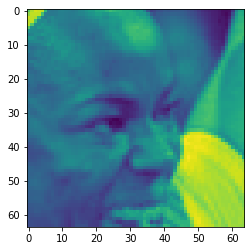

In [ ]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break
    
# num minibatches 
print(len(train_loader))

print(faces_dataset[0][0][0].shape)
plt.imshow(faces_dataset[0][0][0])

In [ ]:
generator_faces = Generator(hidden_dim)
discriminator_faces = Discriminator(hidden_dim)

d_optim_faces, g_optim_faces = torch.optim.Adam(
    discriminator_faces.parameters(), lr=0.001, betas=[0.5, 0.999]
), torch.optim.Adam(
    generator_faces.parameters(), lr=0.001, betas=[0.5, 0.999]
)
criterion = torch.nn.BCELoss()

Epoch:  0
Discriminator Real Loss:  tensor(0.7085, grad_fn=<BinaryCrossEntropyBackward0>)


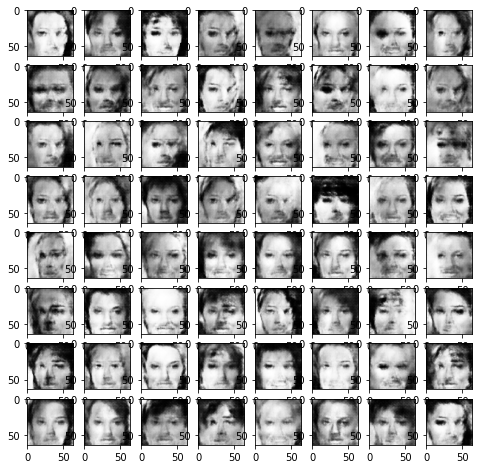

Epoch:  0
Discriminator Real Loss:  tensor(0.1276, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.2065, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(5.0181, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  0
Discriminator Real Loss:  tensor(0.3566, grad_fn=<BinaryCrossEntropyBackward0>)


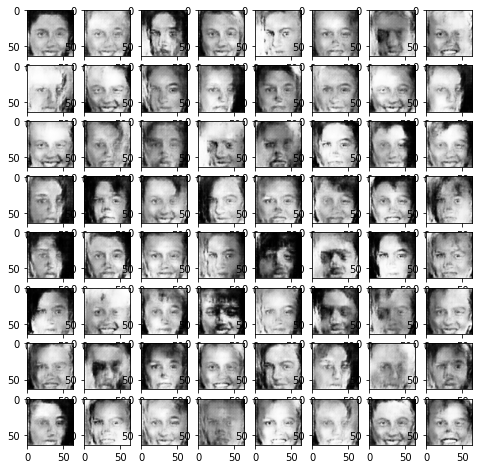

Epoch:  0
Discriminator Real Loss:  tensor(0.0626, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.1853, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(5.6853, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  0
Discriminator Real Loss:  tensor(0.0206, grad_fn=<BinaryCrossEntropyBackward0>)


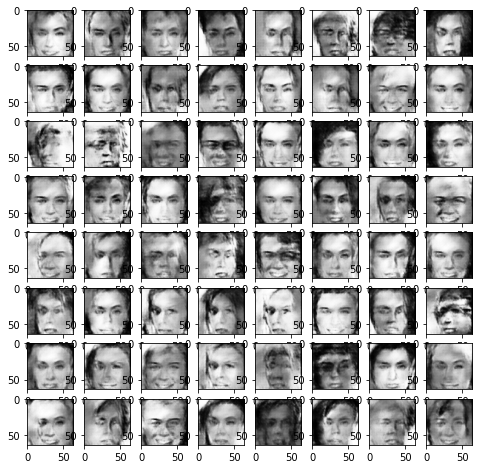

Epoch:  0
Discriminator Real Loss:  tensor(0.0242, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.6943, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(8.9365, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  0
Discriminator Real Loss:  tensor(0.1271, grad_fn=<BinaryCrossEntropyBackward0>)


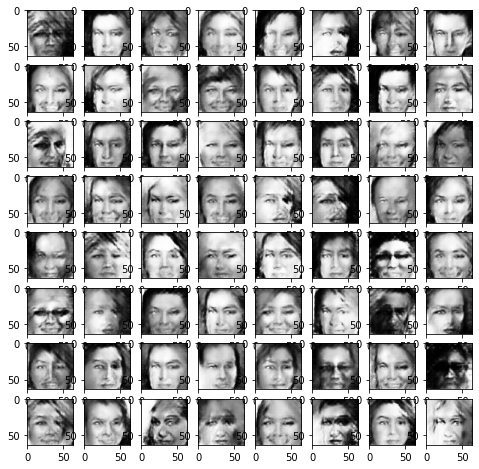

Epoch:  0
Discriminator Real Loss:  tensor(0.0884, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.5417, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(5.9988, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  0
Discriminator Real Loss:  tensor(0.0168, grad_fn=<BinaryCrossEntropyBackward0>)


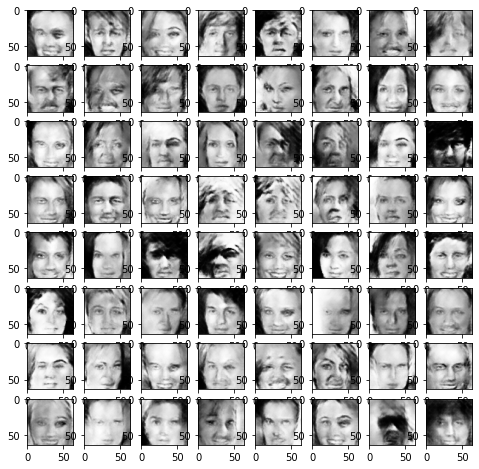

Epoch:  0
Discriminator Real Loss:  tensor(0.4191, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.0401, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(4.7463, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  0
Discriminator Real Loss:  tensor(0.0742, grad_fn=<BinaryCrossEntropyBackward0>)


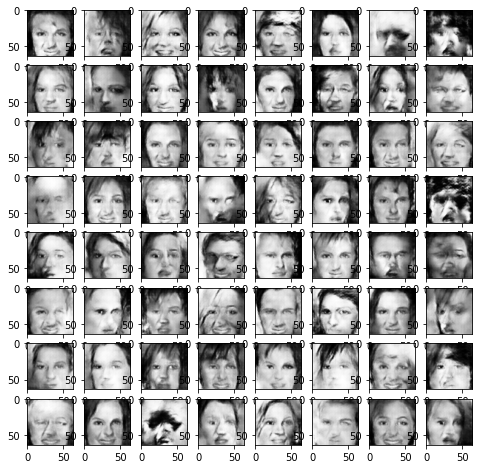

Epoch:  0
Discriminator Real Loss:  tensor(0.3928, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.2372, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(3.9555, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  0
Discriminator Real Loss:  tensor(0.1696, grad_fn=<BinaryCrossEntropyBackward0>)


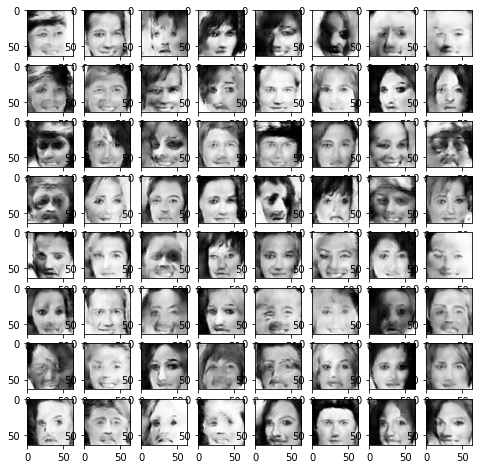

Epoch:  0
Discriminator Real Loss:  tensor(0.3024, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.4398, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(4.1580, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Discriminator Real Loss:  tensor(0.3142, grad_fn=<BinaryCrossEntropyBackward0>)


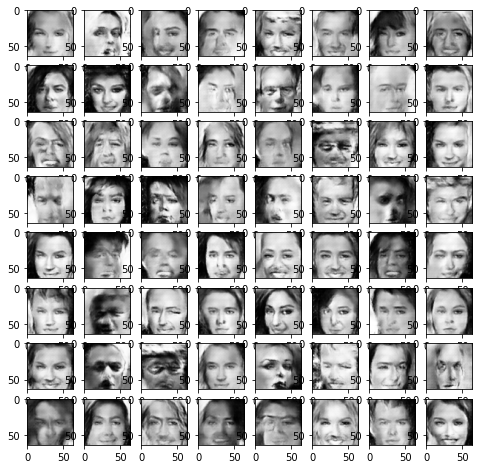

Epoch:  1
Discriminator Real Loss:  tensor(0.7171, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.0440, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(2.8374, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Discriminator Real Loss:  tensor(0.2630, grad_fn=<BinaryCrossEntropyBackward0>)


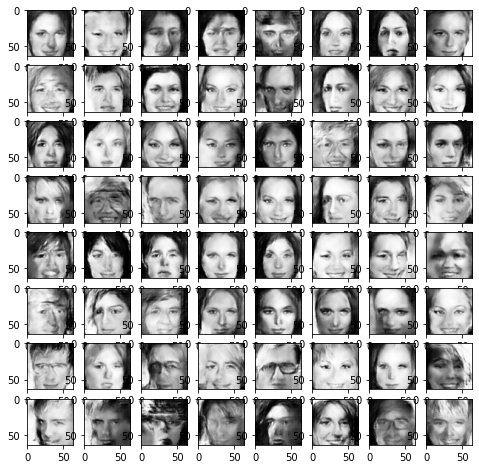

Epoch:  1
Discriminator Real Loss:  tensor(0.2293, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.5207, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(3.9846, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Discriminator Real Loss:  tensor(0.7693, grad_fn=<BinaryCrossEntropyBackward0>)


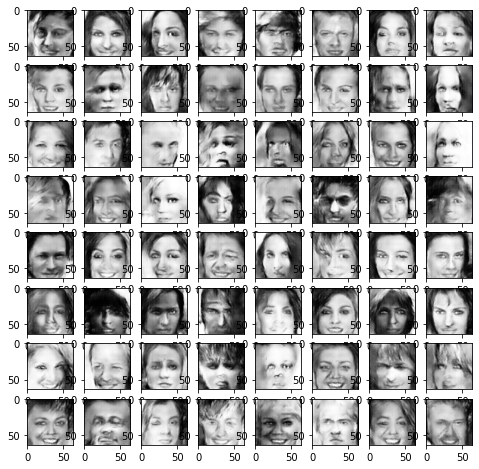

Epoch:  1
Discriminator Real Loss:  tensor(0.2434, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.1895, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(3.2659, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Discriminator Real Loss:  tensor(0.3080, grad_fn=<BinaryCrossEntropyBackward0>)


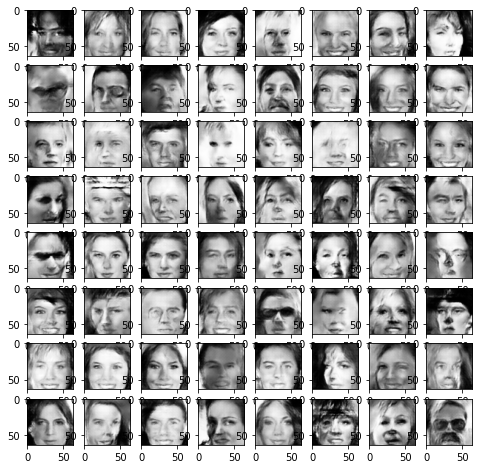

Epoch:  1
Discriminator Real Loss:  tensor(0.4934, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.2602, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(2.5101, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Discriminator Real Loss:  tensor(0.4612, grad_fn=<BinaryCrossEntropyBackward0>)


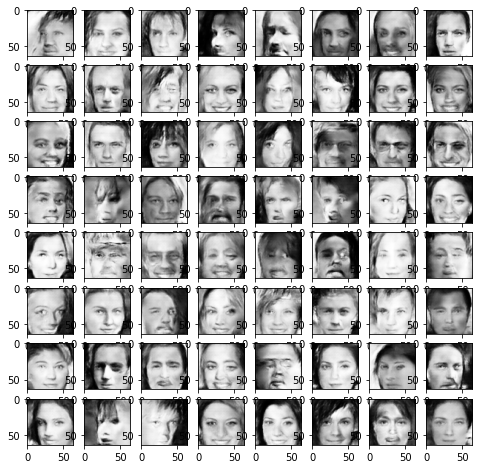

Epoch:  1
Discriminator Real Loss:  tensor(0.0465, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.7539, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(5.7432, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Discriminator Real Loss:  tensor(0.3268, grad_fn=<BinaryCrossEntropyBackward0>)


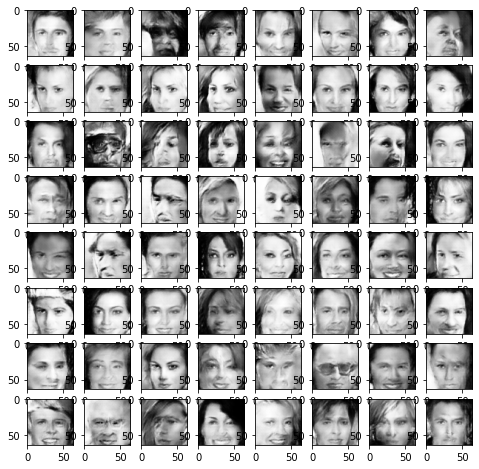

Epoch:  1
Discriminator Real Loss:  tensor(0.1157, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.7459, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(5.2519, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Discriminator Real Loss:  tensor(0.1284, grad_fn=<BinaryCrossEntropyBackward0>)


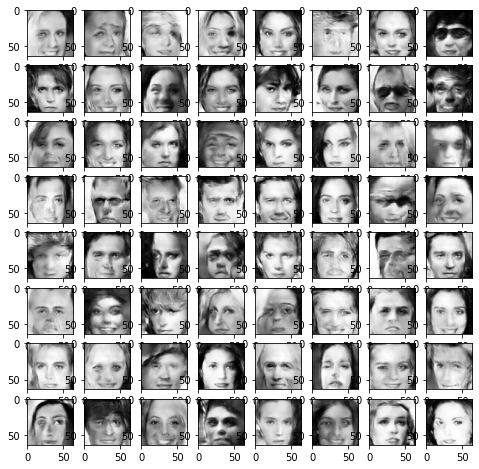

Epoch:  1
Discriminator Real Loss:  tensor(0.3638, grad_fn=<BinaryCrossEntropyBackward0>)
Discriminator Fake Loss:  tensor(0.1415, grad_fn=<BinaryCrossEntropyBackward0>)
Generator Real Loss:  tensor(3.2224, grad_fn=<BinaryCrossEntropyBackward0>)


In [ ]:
train_v1(train_loader, generator_faces, discriminator_faces, d_optim_faces, g_optim_faces, num_epochs=2, print_in_color=False)